## Задача классификации на примере датасета wine-quality

In [1]:
import kaggle
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
os.getcwd()
# os.chdir('/environment/notebooks/DS PRojects')

'/environment/notebooks/DS PRojects'

In [3]:
name = 'rajyellow46/wine-quality'
destination = 'datasets'
%run scripts/ds_load.py {name} {destination}

In [4]:
df = pd.read_csv('datasets/winequalityN.csv')
df.head(3)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
df[['quality', 'type']].nunique()

quality    7
type       2
dtype: int64

In [8]:
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

Сильный дисбаланс классов

/tmp/ipykernel_29/1865469051.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

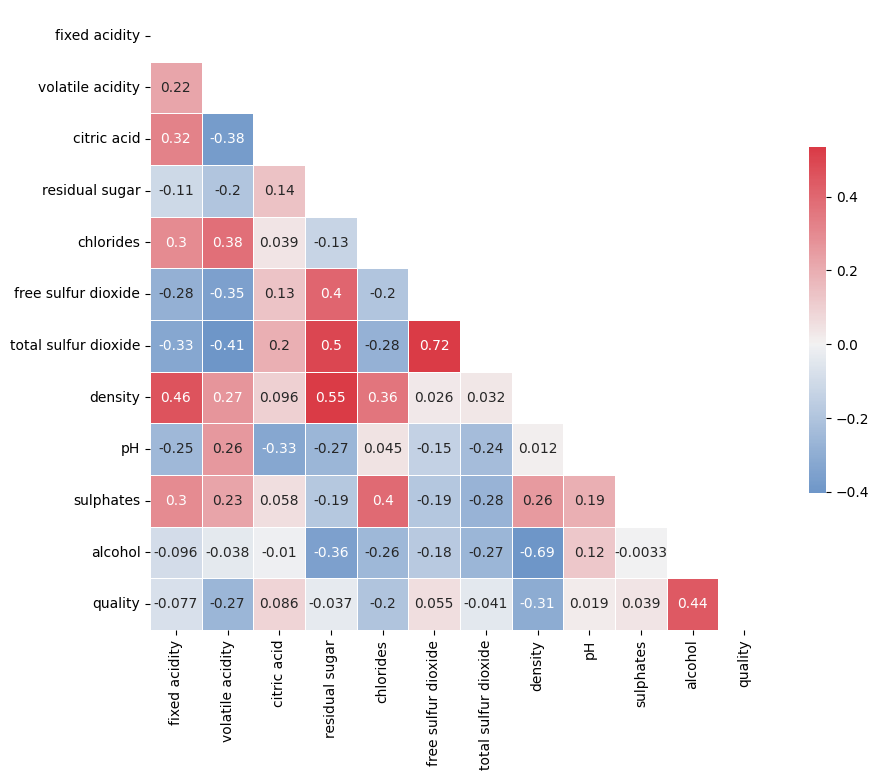

In [9]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(10, 9))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, robust = True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Есть несколько скореллированных признаков. На работу random forest повлиять не должны

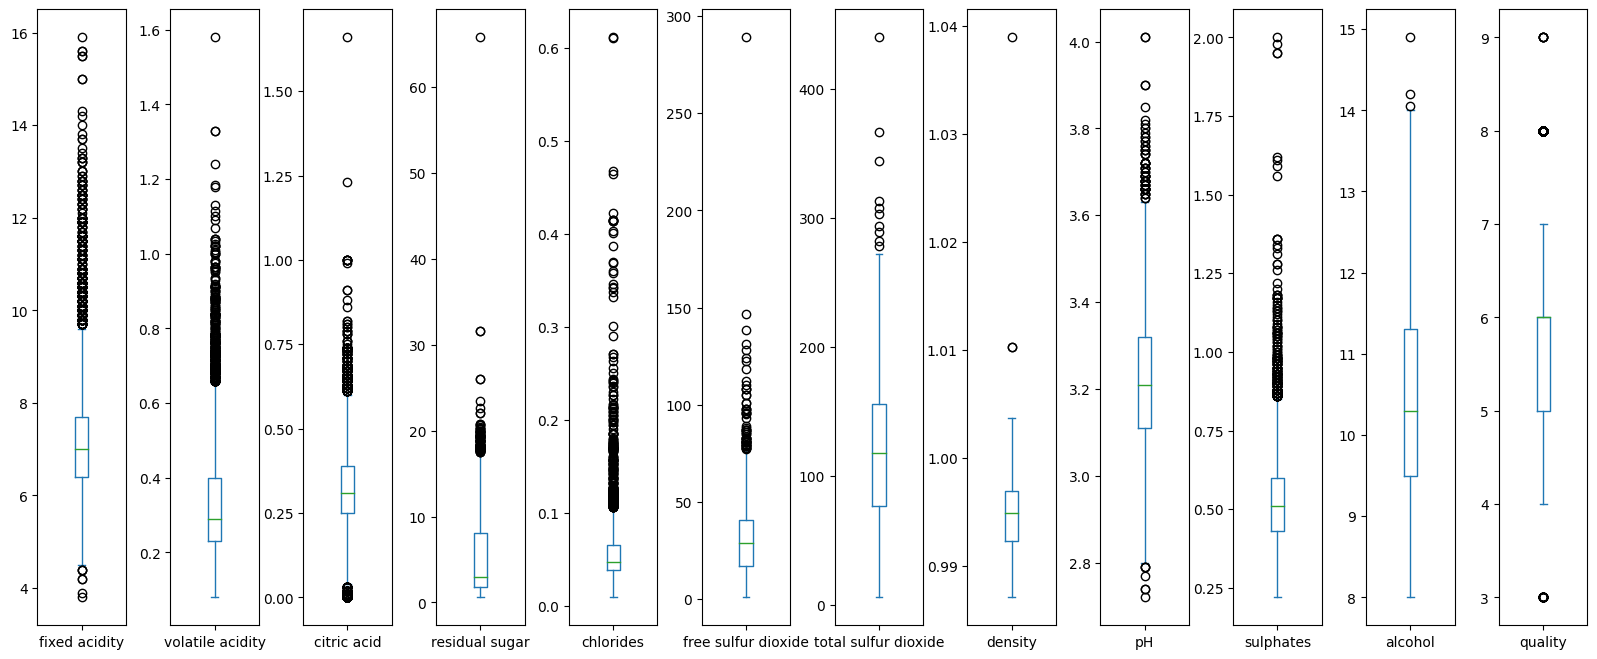

In [10]:
df.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(20, 8))

plt.subplots_adjust(wspace=0.5) 
plt.show()

базовая модель - Дерево решений с настройками по умолчанию. 
Без предобработки данных кроме one-hot кодирования столбца type и заполнения нулевых значений.

In [11]:
df = pd.get_dummies(df, columns = ['type'], drop_first = True)

In [12]:
X = df.drop(['quality'], axis = 1)
y = df['quality']

In [13]:
imp = IterativeImputer(max_iter=10, random_state=0)
X_imp = imp.fit_transform(X)

In [14]:
print(np.count_nonzero(np.isnan(X)),'\n', np.count_nonzero(np.isnan(X_imp)))

38 
 0


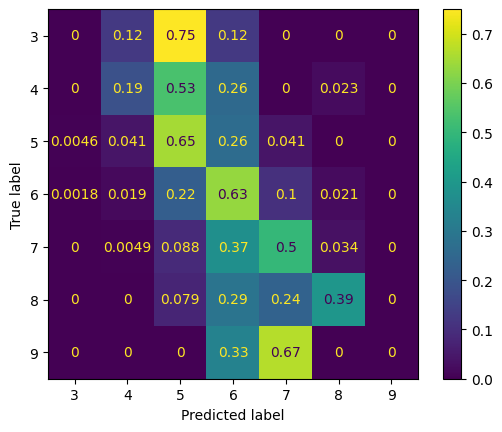


 train score: 1.0 
 test score: 0.5892307692307692 

Decision Tree report: 

               precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.21      0.19      0.20        43
           5       0.61      0.65      0.63       435
           6       0.63      0.63      0.63       569
           7       0.54      0.50      0.52       204
           8       0.43      0.39      0.41        38
           9       0.00      0.00      0.00         3

    accuracy                           0.59      1300
   macro avg       0.34      0.34      0.34      1300
weighted avg       0.58      0.59      0.59      1300



In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state = 666)
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

dt.fit(X_train, y_train)
train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)
clf_rep = classification_report(y_test, dt.predict(X_test), zero_division = 0)
   
predictions = dt.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels = dt.classes_, normalize = 'true')
    
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=dt.classes_)
    
disp.plot()
plt.show()
print('\n', 'train score:', dt.score(X_train, y_train), '\n',
        'test score:', dt.score(X_test, y_test), '\n')

print('Decision Tree report:', '\n'*2, clf_rep)

In [16]:
def random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 666)
    forest = RandomForestClassifier(random_state = 42,
                                    n_estimators = 500,
                                    class_weight = 'balanced',
                                    min_samples_split = 6,
                                    )
    forest.fit(X_train, y_train)
    train_score = forest.score(X_train, y_train)
    test_score = forest.score(X_test, y_test)
    clf_rep = classification_report(y_test, forest.predict(X_test), zero_division = 0)
    
    predictions = forest.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels = forest.classes_, normalize = 'true')
    
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=forest.classes_)
    
    disp.plot()
    plt.show()
    print('\n', 'train score:', forest.score(X_train, y_train), '\n',
        'test score:', forest.score(X_test, y_test), '\n')

    print('Random forest report:', '\n'*2, clf_rep)

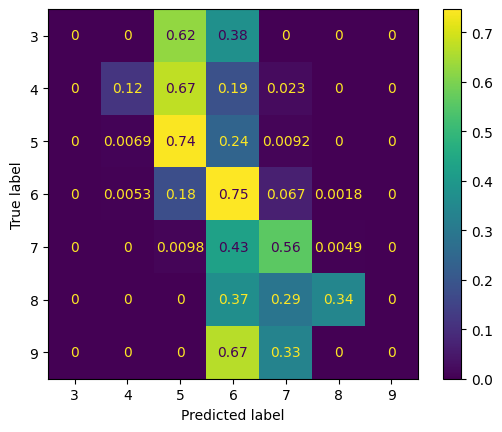


 train score: 0.9982682316721185 
 test score: 0.676923076923077 

Random forest report: 

               precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.45      0.12      0.19        43
           5       0.70      0.74      0.72       435
           6       0.66      0.75      0.70       569
           7       0.67      0.56      0.61       204
           8       0.87      0.34      0.49        38
           9       0.00      0.00      0.00         3

    accuracy                           0.68      1300
   macro avg       0.48      0.36      0.39      1300
weighted avg       0.67      0.68      0.66      1300



In [17]:
random_forest(X_imp, y)

Данные несбалансированы. Модель не смогла предсказать классы 3 и 9. 

In [18]:
# Устранение дисбаланса классов при помощи SMOTE
sm = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=4, n_jobs=None)
X_res, y_res = sm.fit_resample(X_imp, y)

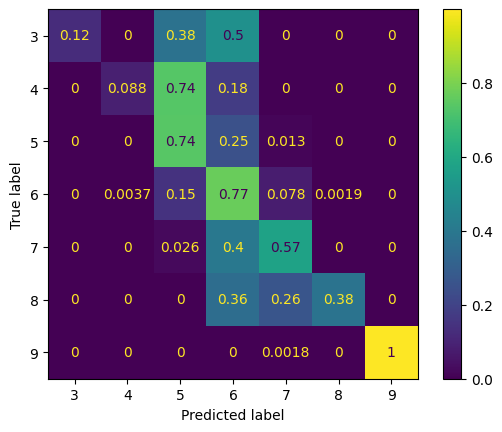


 train score: 0.9977217904047172 
 test score: 0.7834941050375134 

Random forest report: 

               precision    recall  f1-score   support

           3       1.00      0.12      0.22         8
           4       0.60      0.09      0.15        34
           5       0.74      0.74      0.74       445
           6       0.64      0.77      0.70       538
           7       0.69      0.57      0.63       232
           8       0.94      0.38      0.54        42
           9       1.00      1.00      1.00       567

    accuracy                           0.78      1866
   macro avg       0.80      0.52      0.57      1866
weighted avg       0.79      0.78      0.78      1866



In [19]:
random_forest(X_res, y_res)

уберем скореллированные признаки и попробуем еще раз

In [20]:
X2 = df.drop(['total sulfur dioxide', 'density', 'quality'], axis = 1)
y2 = df['quality']

In [21]:
X2_imp = imp.fit_transform(X2)
X2_res, y2_res = sm.fit_resample(X2_imp, y2)

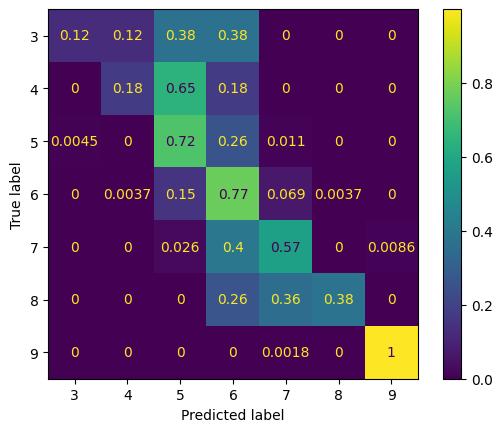


 train score: 0.9969177164299116 
 test score: 0.7808145766345124 

Random forest report: 

               precision    recall  f1-score   support

           3       0.33      0.12      0.18         8
           4       0.67      0.18      0.28        34
           5       0.74      0.72      0.73       445
           6       0.64      0.77      0.70       538
           7       0.69      0.57      0.63       232
           8       0.89      0.38      0.53        42
           9       1.00      1.00      1.00       567

    accuracy                           0.78      1866
   macro avg       0.71      0.53      0.58      1866
weighted avg       0.78      0.78      0.78      1866



In [22]:
random_forest(X2_res, y2_res)

Результат стал незначительно хуже

#### Настройка гиперпараметров с помощью RandomizedSearchCV

In [23]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category = Warning)

param_grid = {
    'n_estimators': [300, 500, 700, 1000],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [3, 5, 7, 10, None],
    'max_depth': [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)],
    'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
    'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_leaf_nodes': [None, 2, 5, 7, 10],
    'oob_score': [True, False],
    'class_weight': ['balanced', None]}


X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state = 666)

forest = RandomForestClassifier()
rand_search = RandomizedSearchCV(forest, 
                                 param_grid,
                                 n_iter = 200,
                                 cv=3, 
                                 n_jobs=-1, 
                                 verbose=1, 
                                 return_train_score = True)

rand_search.fit(X_train, y_train)
best_estim = rand_search.best_estimator_
best_score = rand_search.best_score_
best_params = [best_score, best_estim]

# best_forest = sorted(best_params, key=lambda x: x[0])[-1][1]
print(best_params)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[0.7142857758522236, RandomForestClassifier(criterion='entropy', max_depth=11, max_features='log2',
                       min_samples_leaf=2, min_samples_split=34,
                       n_estimators=500)]


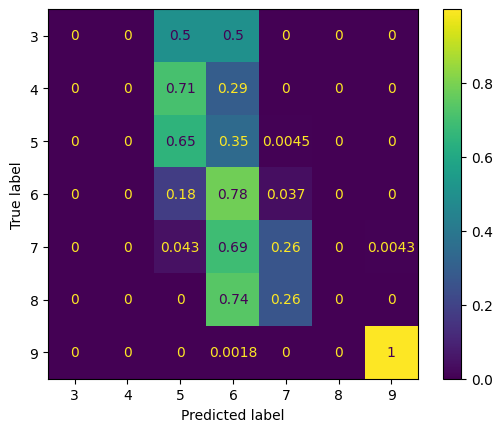


 train score: 0.7909407665505227 
 test score: 0.7159699892818864 

Random forest report: 

               precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        34
           5       0.68      0.65      0.66       445
           6       0.54      0.78      0.64       538
           7       0.65      0.26      0.37       232
           8       0.00      0.00      0.00        42
           9       1.00      1.00      1.00       567

    accuracy                           0.72      1866
   macro avg       0.41      0.38      0.38      1866
weighted avg       0.70      0.72      0.69      1866



In [24]:
forest = best_estim
forest.fit(X_train, y_train)
train_score = forest.score(X_train, y_train)
test_score = forest.score(X_test, y_test)
clf_rep = classification_report(y_test, forest.predict(X_test), zero_division = 0)
    
predictions = forest.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels = forest.classes_, normalize = 'true')
    
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=forest.classes_)
    
disp.plot()
plt.show()
print('\n', 'train score:', forest.score(X_train, y_train), '\n',
        'test score:', forest.score(X_test, y_test), '\n')
print('Random forest report:', '\n'*2, clf_rep)

In [25]:
rs_df = pd.DataFrame(rand_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_oob_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,param_class_weight,param_bootstrap,mean_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,False,500,34,2,None,log2,11,entropy,None,True,0.714286,1,0.785887,0.783719,0.788945,0.786183,0.002144
1,True,1000,50,2,None,sqrt,11,entropy,None,True,0.702761,2,0.754725,0.756784,0.758392,0.756633,0.001501
2,False,700,50,28,None,log2,14,entropy,None,False,0.698338,3,0.742461,0.747337,0.746734,0.745510,0.002170
3,True,500,34,39,None,log2,12,entropy,None,True,0.684267,4,0.700241,0.701307,0.704523,0.702023,0.001820
4,True,1000,2,44,None,sqrt,10,entropy,None,True,0.682927,5,0.693808,0.699497,0.701307,0.698204,0.003195
5,False,700,2,18,None,log2,5,gini,None,True,0.681587,6,0.699236,0.698492,0.699698,0.699142,0.000497
6,False,500,7,2,10,sqrt,11,gini,None,True,0.674886,7,0.679735,0.683015,0.676382,0.679711,0.002708
7,False,300,2,28,10,log2,9,entropy,None,False,0.671804,8,0.676317,0.678392,0.672965,0.675891,0.002236
8,False,700,44,18,10,log2,5,gini,None,False,0.671268,9,0.678930,0.681407,0.671357,0.677231,0.004275
9,False,1000,34,12,7,sqrt,14,entropy,None,True,0.671267,10,0.676719,0.681005,0.669950,0.675891,0.004551


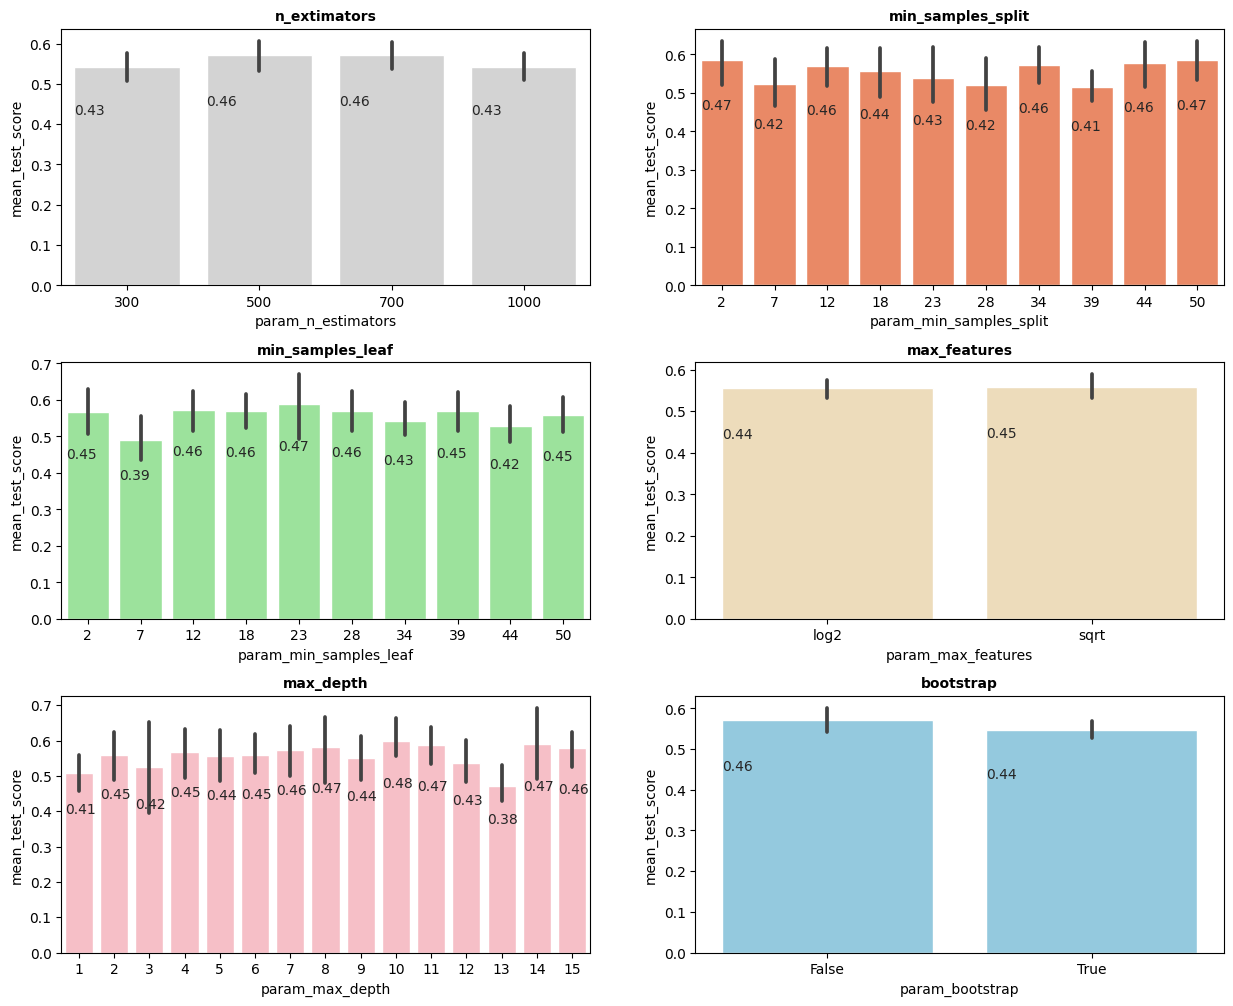

In [26]:
fig, axs = plt.subplots(ncols=2, nrows=3)
sns.set(style="whitegrid", color_codes=True)

fig.set_size_inches(15,12)
fig.subplots_adjust(hspace=0.3)

def add_values_on_bars(axs, spacing=5):
    for ax in axs.flat:
        for rect in ax.patches:
            y_bottom = rect.get_y()
            height = rect.get_height()
            y_bottom -= height
            height += height * spacing * -.1
            width = rect.get_width()
            x_value = rect.get_x()
            ax.text(x_value, height, f"{height:.2f}", ha='left', va='center', size = 10)
            
            
axs[0,0].set_title(label = 'n_extimators', size=10, weight='bold')
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_title(label = 'min_samples_split', size=10, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[1,0], color='lightgreen')
axs[1,0].set_title(label = 'min_samples_leaf', size=10, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,1], color='wheat')
axs[1,1].set_title(label = 'max_features', size=10, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[2,0], color='lightpink')
axs[2,0].set_title(label = 'max_depth', size=10, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[2,1], color='skyblue')
axs[2,1].set_title(label = 'bootstrap', size=10, weight='bold')

add_values_on_bars(axs, spacing=2)

plt.show()


In [139]:
print(ax.text.__doc__)

Add text to the Axes.

Add the text *s* to the Axes at location *x*, *y* in data coordinates.

Parameters
----------
x, y : float
    The position to place the text. By default, this is in data
    coordinates. The coordinate system can be changed using the
    *transform* parameter.

s : str
    The text.

fontdict : dict, default: None
    A dictionary to override the default text properties. If fontdict
    is None, the defaults are determined by `.rcParams`.

Returns
-------
`.Text`
    The created `.Text` instance.

Other Parameters
----------------
**kwargs : `~matplotlib.text.Text` properties.
    Other miscellaneous text parameters.

    Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
    alpha: scalar or None
    animated: bool
    backgroundcolor: color
    bbox: dict with properties for `.patches.FancyBboxPatch`
    clip_box: unknown
    

In [27]:
n_estimators = [1000]
max_features = ['log2']
max_depth = [3, 6, 9, 14]
min_samples_split = [28]
min_samples_leaf = [7, 28]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(forest, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_gc = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'bootstrap': False,
 'max_depth': 14,
 'max_features': 'log2',
 'min_samples_leaf': 7,
 'min_samples_split': 28,
 'n_estimators': 1000}

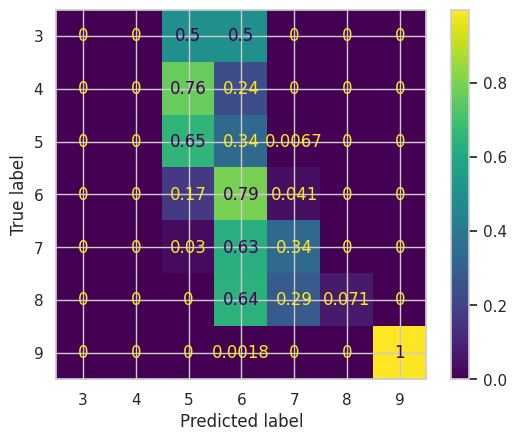


 train score: 0.8572768694719914 
 test score: 0.7315112540192926 

Random forest report: 

               precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        34
           5       0.70      0.65      0.67       445
           6       0.56      0.79      0.65       538
           7       0.68      0.34      0.45       232
           8       1.00      0.07      0.13        42
           9       1.00      1.00      1.00       567

    accuracy                           0.73      1866
   macro avg       0.56      0.41      0.42      1866
weighted avg       0.74      0.73      0.71      1866



In [28]:
forest = rfc_gc
forest.fit(X_train, y_train)
train_score = forest.score(X_train, y_train)
test_score = forest.score(X_test, y_test)
clf_rep = classification_report(y_test, forest.predict(X_test), zero_division = 0)
    
predictions = forest.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels = forest.classes_, normalize = 'true')
    
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels=forest.classes_)
    
disp.plot()
plt.show()
print('\n', 'train score:', forest.score(X_train, y_train), '\n',
        'test score:', forest.score(X_test, y_test), '\n')
print('Random forest report:', '\n'*2, clf_rep)